# Single 1-min soundscape process to extract nROI and aROI

## 1. Load packages

In [1]:
# -*- coding: utf-8 -*-
"""
Updated 13 January 2026
Author: Sylvain Haupert
"""

from IPython import get_ipython
print(__doc__)

# Clear all the variables
get_ipython().run_line_magic('reset', '-sf')

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Import standard libraries
from pathlib import Path  
import sys
import os
import random
from glob import glob
import matplotlib.pyplot as plt

# Import configuration file
import sys
sys.path.append(str(Path('../src')))
import config as cfg

# Import maad package
from maad import sound, features

# Close all the figures (like in Matlab)
plt.close("all")



Updated 13 January 2026
Author: Sylvain Haupert



## 2. Notebook init and options setting

* Select the option and the configuration file
* Select a sound from a dataset

In [2]:
"""==============================================================================
    options             
=============================================================================="""

VERBOSE = True
CONFIG = cfg.load_config('config_publication.yaml')

In [3]:
"""==============================================================================
    select a sound from a dataset   
=============================================================================="""

# OPTION 1 : Select a random dataset from the config file
# -------------------------------------------------------
DATASET = CONFIG['datasets'][random.randint(0, len(CONFIG['datasets']) - 1)]
path = Path(DATASET['path']) 
# select a random .wav file from the dataset
f = random.choice(glob(str(path / '*.wav')))

# # OPTION 2 :  Select a dataset, for instance 'risoux'
# # -------------------------------------------------------
# # in the list find the dictionary with the key 'name' and the value 'risoux'
# DATASET = [d for d in CONFIG['datasets'] if d['name'] == 'risoux'][0]
# path = Path(DATASET['path']) 
# # select a random .wav file from the dataset
# # f = random.choice(glob(str(path / '*.wav')))
# # or select a specific file
# f = path / 'S4A03536_20190624_051500.wav' # chorus

# retrieve filename
_, filename_with_ext = os.path.split(f)
file = os.path.splitext(filename_with_ext)[0]

display('Selected dataset: {}'.format(DATASET['name']))
display('Processing {}.wav ...'.format(file))



'Selected dataset: hawai'

'Processing UHH_502_S02_20210327_062000_00.wav ...'

## 3. Process a single audio file to extract nROI and aROI
* Load the audio file
* Resample the audio
* Bandpass filter and trim the audio if needed
* Compute the spectrogram
* Apply the region_of_interest_index function from scikit-maad
* Display intermediate spectrograms results
* Play the sound (optional)

spectrogram dimension Nx=513 Ny=5166
max value of the spectrogram 0.00091
*************************************************************
   Time resolution dt=0.01s | Frequency resolution df=43.07Hz 
*************************************************************
seed_level 16dB / low_level 6dB
===> Number of ROIs before cleaning : 360
===> Number of ROIs after cleaning : 257
===> nROI : 257#/min | aROI : 4.95%


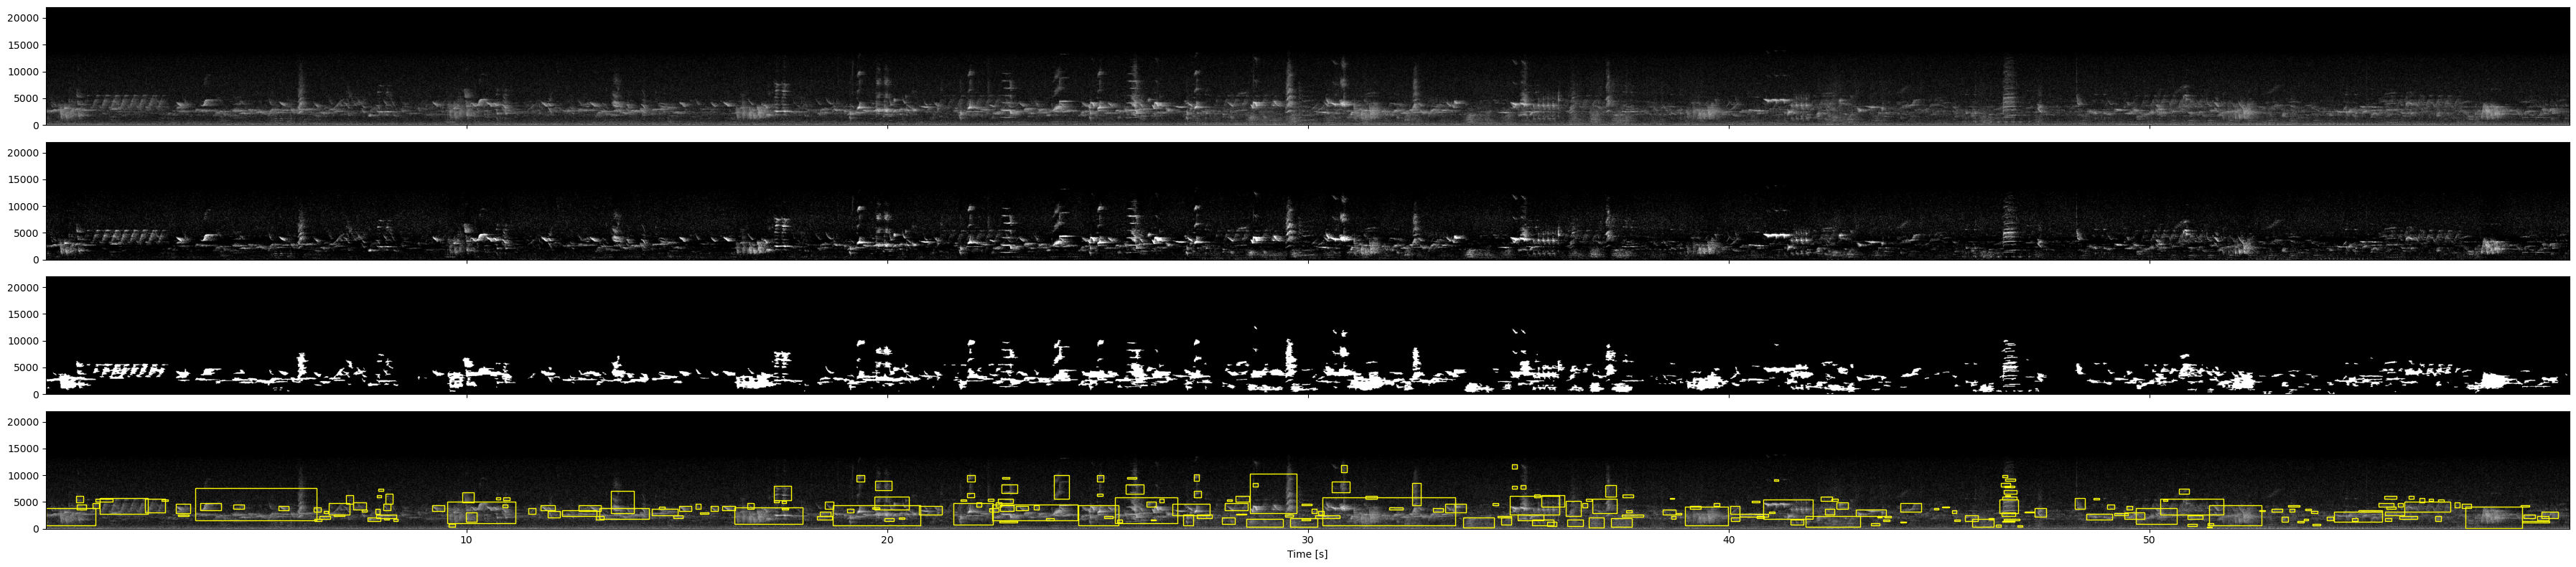

In [4]:
"""==============================================================================
    Process 1-min soundscape to extract nROI and aROI indices
    -------------------------------------------------------------
    Summary of the steps:
    ---------------------
    - Load the sound file
    - Resample to SAMPLING_FREQUENCY
    - Bandpass filter between BW_FREQ_MIN and BW_FREQ_MAX
    - Trim the sound between T_START and T_END
    - Compute the Power Spectrogram Density (PSD)
    - Compute nROI and aROI with maad

=============================================================================="""

# Load the original sound (16bits) and get the sampling frequency fs
# try:
wave, fs = sound.load(
    filename=f,
    channel=CONFIG['channel'], 
    detrend=True, 
    verbose=False
    )

# resample to SAMPLING_FREQUENCY and update fs
wave = sound.resample(
    s=wave,
    fs=fs,
    target_fs=CONFIG['sampling_frequency'],
    )
fs = CONFIG['sampling_frequency']
duration = len(wave) / fs

# bandpass filter between BW_FREQ_MIN and BW_FREQ_MAX
if (DATASET['flim_min'] is not None) and (DATASET['flim_max'] is not None):   
    wave = sound.select_bandwidth(
        x=wave, 
        fs=fs, 
        fcut=(DATASET['flim_min'],DATASET['flim_max'] ), 
        forder = 5,
        ftype='bandpass')
elif DATASET['flim_max'] is not None:
    wave = sound.select_bandwidth(
        x=wave, 
        fs=fs, 
        fcut=(DATASET['flim_max']), 
        forder = 5,
        ftype='low')
elif DATASET['flim_min'] is not None :
    wave = sound.select_bandwidth(
        x=wave, 
        fs=fs, 
        fcut=(DATASET['flim_min']), 
        forder = 5,
        ftype='high')

# trim
if (DATASET['tlim_min'] is not None) and (DATASET['tlim_max'] is not None):
    wave = sound.trim(
        s=wave, 
        fs=fs,
        min_t=DATASET['tlim_min'],
        max_t=DATASET['tlim_max'] )
elif (DATASET['tlim_min'] is not None):
    wave = sound.trim(
        s=wave, 
        fs=fs,
        min_t=DATASET['tlim_min'],
        max_t=duration)
elif (DATASET['tlim_max'] is not None):
    wave = sound.trim(
        s=wave, 
        fs=fs,
        min_t=0,
        max_t=DATASET['tlim_max'] )

# Compute the Power Spectrogram Density (PSD) : Sxx_power
Sxx_power, tn, fn, ext = sound.spectrogram(
    wave,fs,
    window=CONFIG['window'],
    nperseg=CONFIG['n_fft'],
    noverlap=CONFIG['hop_length'],
    verbose=VERBOSE,
    display=False,
    savefig=None)

# cCompute nROI and aROI with maad
nROI, aROI = features.region_of_interest_index(
    Sxx_power, tn, fn,   
    seed_level=CONFIG['seed_level'], 
    low_level=CONFIG['low_level'], 
    fusion_rois=CONFIG['fusion_rois'],
    remove_rois_flim_min = CONFIG['remove_rois_flim_min'],
    remove_rois_flim_max = CONFIG['remove_rois_flim_max'],
    remove_rain = CONFIG['remove_rain'],
    min_event_duration=CONFIG['min_event_duration'], 
    max_event_duration=CONFIG['max_event_duration'], 
    min_freq_bw=CONFIG['min_freq_bw'], 
    max_freq_bw=CONFIG['max_freq_bw'], 
    max_ratio_xy = CONFIG['max_ratio_xy'],
    display = True,
    verbose=True,
    **{'extent':ext})




In [5]:
"""==============================================================================
    play the sound with ipython 
=============================================================================="""

import IPython.display as ipd
ipd.Audio(wave, rate=fs)